In [1]:
import sys, importlib
importlib.reload(sys.modules['climatology_ensemble'])

KeyError: 'climatology_ensemble'

In [1]:
import sys
sys.path.insert(0, "..")

from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

## A) ALL_VARS, T_UNIT = 10

In [2]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\old\\'

daily_input = pd.read_csv(path+'SAN_BENIGNO_ORCO_2002_2019.csv', index_col=0, parse_dates=True)

daily_input_stat = spatial_stats_daily_input(daily_input)
daily_input_stat=daily_input_stat[[c for c in daily_input_stat.columns if c[0] != 'R']]
t_unit=10


#define the possible parameters value (where Gridsearch is applied)
C_range=np.logspace(-1.5, 1.5, 10)
epsilon_range=np.logspace(-5, -2, 5)
#n_range = [17, 50, 200]
components_range = [5*4*36]

#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=5
test_size=365

In [3]:
daily_input_stat

Q           T          T5         T25         T75         T95  \
2001-01-01   NaN  268.155152  261.507702  265.364962  272.271366  273.519307   
2001-01-02   NaN  270.177107  264.302650  267.927416  273.664145  274.777748   
2001-01-03   NaN  267.817979  259.558975  264.477872  272.885529  274.090143   
2001-01-04   NaN  270.120416  263.151173  267.362912  274.186893  275.165705   
2001-01-05   NaN  270.852392  264.279173  268.329888  274.476690  275.607926   
...          ...         ...         ...         ...         ...         ...   
2018-12-27  6.45  272.145776  267.090469  270.425599  274.753961  276.036066   
2018-12-28  5.90  273.237923  267.701906  271.259924  276.259172  277.323651   
2018-12-29  5.20  272.962407  266.456812  270.543723  276.764507  277.619308   
2018-12-30  4.55  273.819281  266.661643  270.897798  278.047754  278.908324   
2018-12-31  4.42  272.931295  264.933996  269.717175  277.623064  278.619908   

                   E        E5       E25       E75  ...         P  \
2001-01-01  0.689045  0.178590  0.423489  0.885472  ...  0.000030   
2001-01-02  0.290545 -0.010598  0.050870  0.507151  ...  0.175406   
2001-01-03 -0.220721 -0.308394 -0.270721 -0.179357  ...  5.231468   
2001-01-04 -0.021118 -0.276602 -0.170701  0.130182  ...  0.329261   
2001-01-05  0.227969 -0.058524 -0.015644  0.440803  ...  3.561515   
...              ...       ...       ...       ...  ...       ...   
2018-12-27  0.367153 -0.153659 -0.059275  0.804174  ...  0.000003   
2018-12-28  0.142479 -0.208490 -0.126605  0.472813  ...  0.005985   
2018-12-29 -0.150181 -0.392394 -0.240160 -0.066551  ...  0.013349   
2018-12-30  0.333473 -0.171008  0.127160  0.580138  ...  0.000296   
2018-12-31  0.112663 -0.204107 -0.010978  0.251120  ...  0.005474   

                      P5       P25           P75        P95           S   S5  \
2001-01-01  0.000000e+00  0.000002  4.712090e-05   0.000086  215.568627  0.0   
2001-01-02  9.072534e-03  0.022523  2.799427e-01   0.548903  221.274510  0.0   
2001-01-03  2.004129e+00  2.797286  7.397029e+00  10.111353  221.549020  0.0   
2001-01-04  7.340939e-02  0.127479  4.048327e-01   0.878168  225.137255  0.0   
2001-01-05  1.902955e+00  2.211258  4.634279e+00   6.608347  232.784314  0.0   
...                  ...       ...           ...        ...         ...  ...   
2018-12-27 -2.176434e-09  0.000000  8.174076e-07   0.000015  123.901961  0.0   
2018-12-28  7.750391e-06  0.000103  7.961755e-03   0.024801  123.823529  0.0   
2018-12-29  1.952306e-03  0.003203  1.736954e-02   0.049847  123.764706  0.0   
2018-12-30  8.626771e-08  0.000006  4.181671e-04   0.000767  123.470588  0.0   
2018-12-31  6.143626e-04  0.001438  7.782329e-03   0.015520  123.352941  0.0   

            S25    S75    S95  
2001-01-01  5.5  340.5  538.0  
2001-01-02  6.0  350.5  549.5  
2001-01-03  6.0  350.5  550.0  
2001-01-04  5.0  355.0  558.5  
2001-01-05  3.5  369.5  577.5  
...         ...    ...    ...  
2018-12-27  0.0  186.0  448.5  
2018-12-28  0.0  186.0  448.5  
2018-12-29  0.0  186.0  448.5  
2018-12-30  0.0  185.0  448.0  
2018-12-31  0.0  185.0  448.0  

[6574 rows x 21 columns]

In [4]:
C_range=np.logspace(-0.5, 0.5, 8)
epsilon_range=[5.623413251903491e-05]

In [5]:
"""C, eps = SVR_nested_CV_gridsearch(daily_input_stat, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}') """

"C, eps = SVR_nested_CV_gridsearch(daily_input_stat, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)\nprint(f'C={C}')\nprint(f'eps={eps}') "

In [5]:
C=0.848342898244072
eps=5.623413251903491e-05

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [6]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input_stat, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

In [8]:
from climatology_ensemble import  daily_climatology_p_et_ensemble


In [11]:

    #compute the daily climatology and the quantile analysis
    daily_clim = daily_climatology_p_et_ensemble(daily_input_stat,t_unit,radius_for_ensemble)
    #get the input-target matrix
    it_matrix=create_it_matrix(daily_input,t_length,t_unit)
    #split in train-test sets
    tscv = TimeSeriesSplit(gap=t_unit ,n_splits=n_splits, test_size=test_size)
    sets = tscv.split(it_matrix.index)
    j=0;
    prediction=pd.DataFrame(data=None)

> c:\users\mmazzolini\onedrive - scientific network south tyrol\documents\conda\runoff_prediction\sf_runoff.py(96)create_it_matrix()
     94     #pdb.set_trace()
     95     # Create the input-target matrix
---> 96     return pd.concat(output, axis=1).dropna()
     97 
     98 

ipdb> c


In [16]:

    for train_index, test_index in sets:
        #set up training features
        X = it_matrix.drop(columns='Q').iloc[train_index]
        y = it_matrix['Q'].iloc[train_index]
        

In [22]:
train_index

array([   0,    1,    2, ..., 5338, 5339, 5340])

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

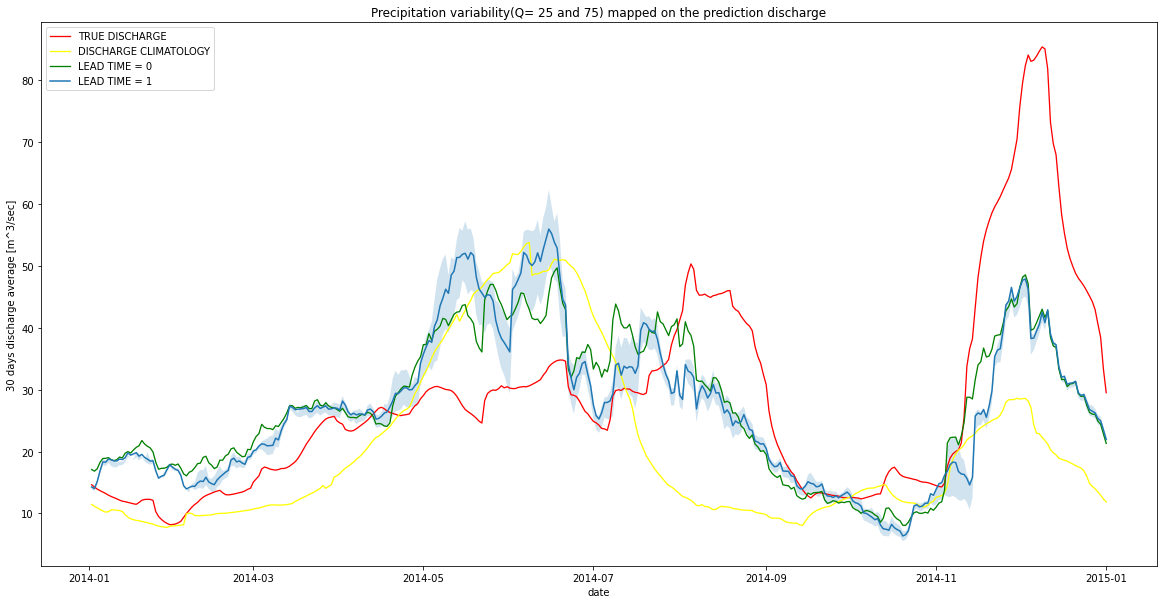

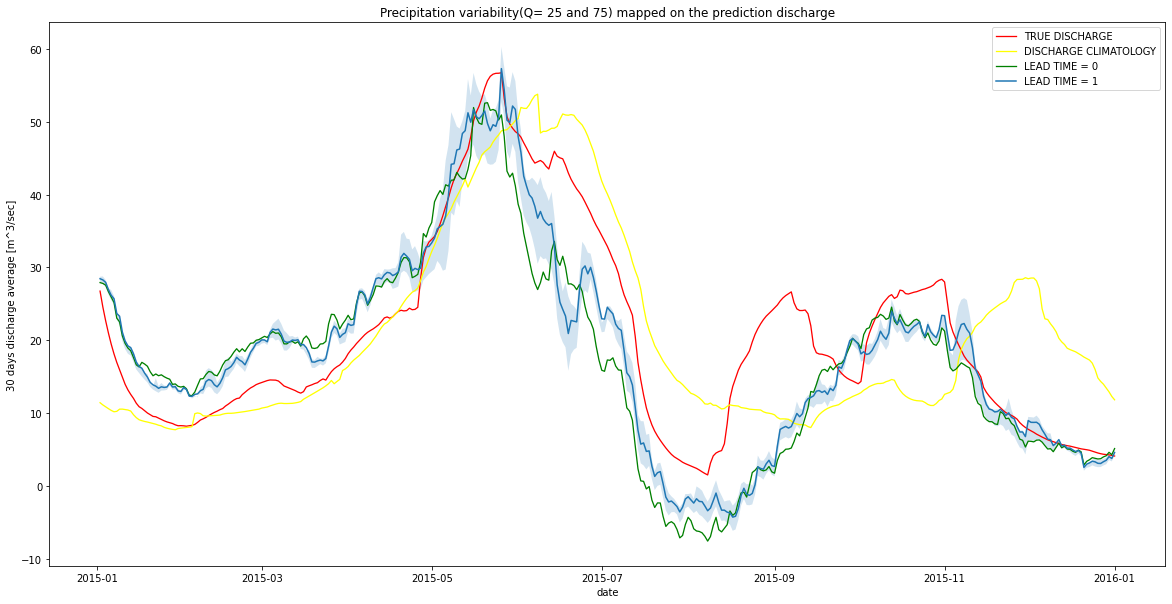

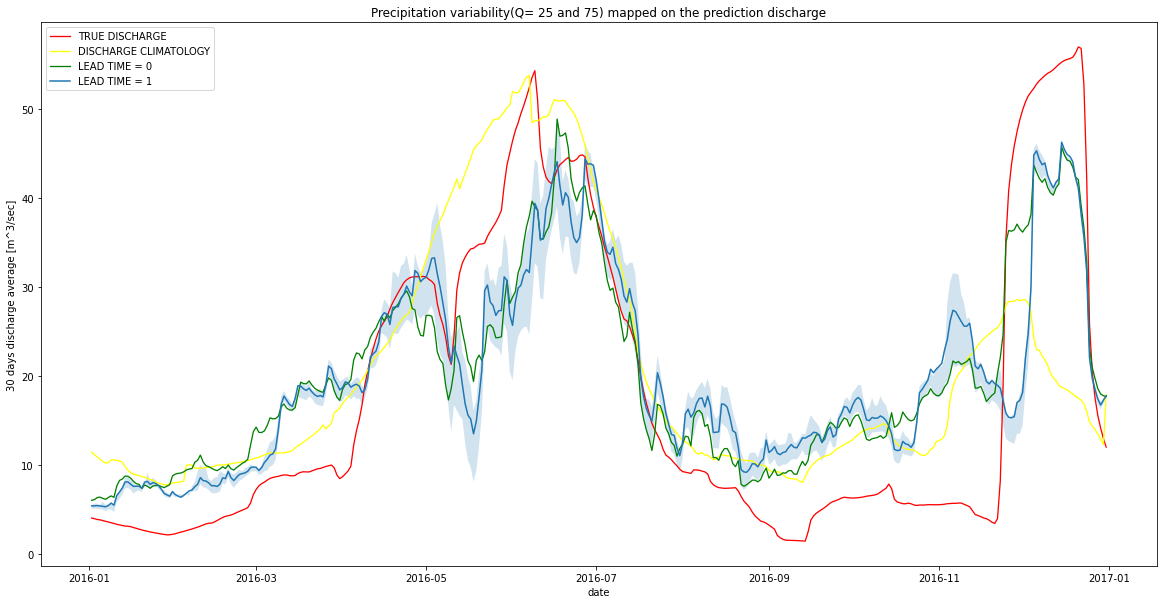

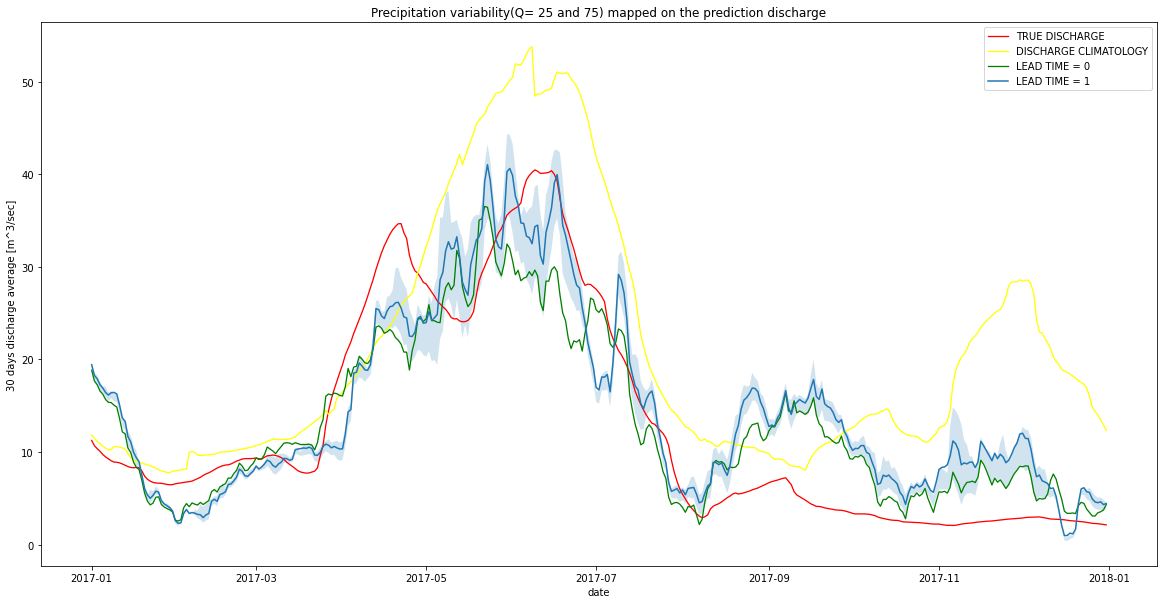

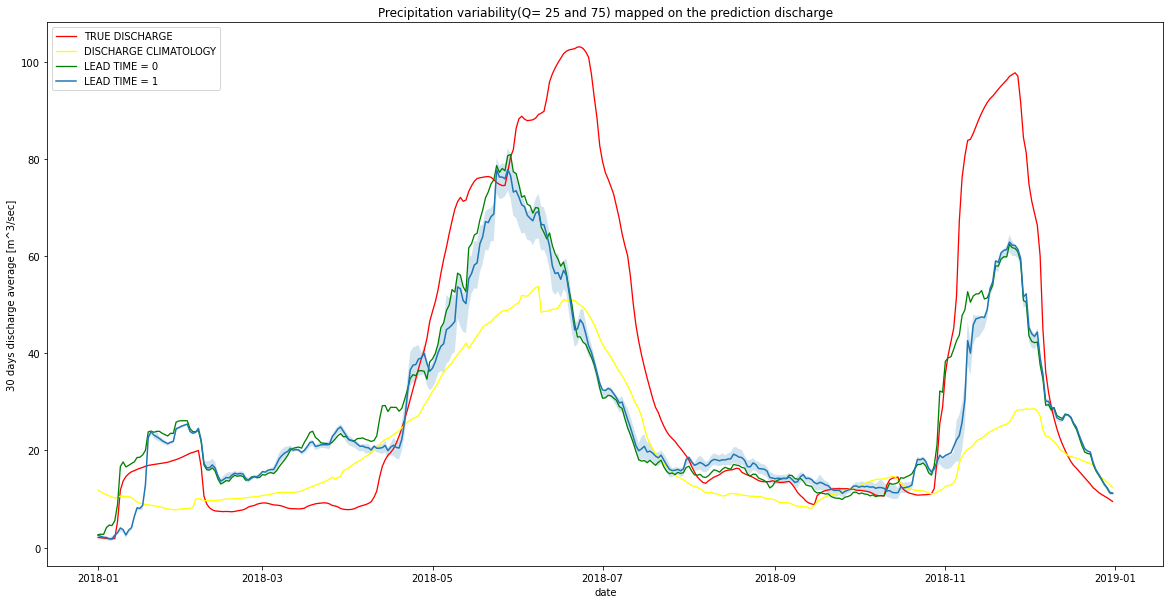

In [7]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)

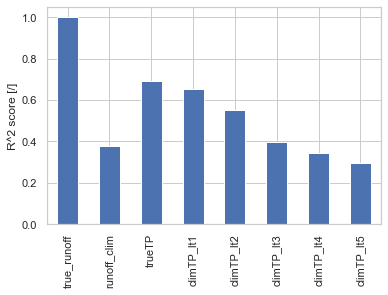

In [97]:
r2_A= evaluate_prediction(predictions)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [98]:
predictions_for_clim = classic_CV_SVR_predict(daily_input_stat, C, eps, t_length,t_unit, n_splits)

In [99]:
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index


In [ ]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.scatterplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

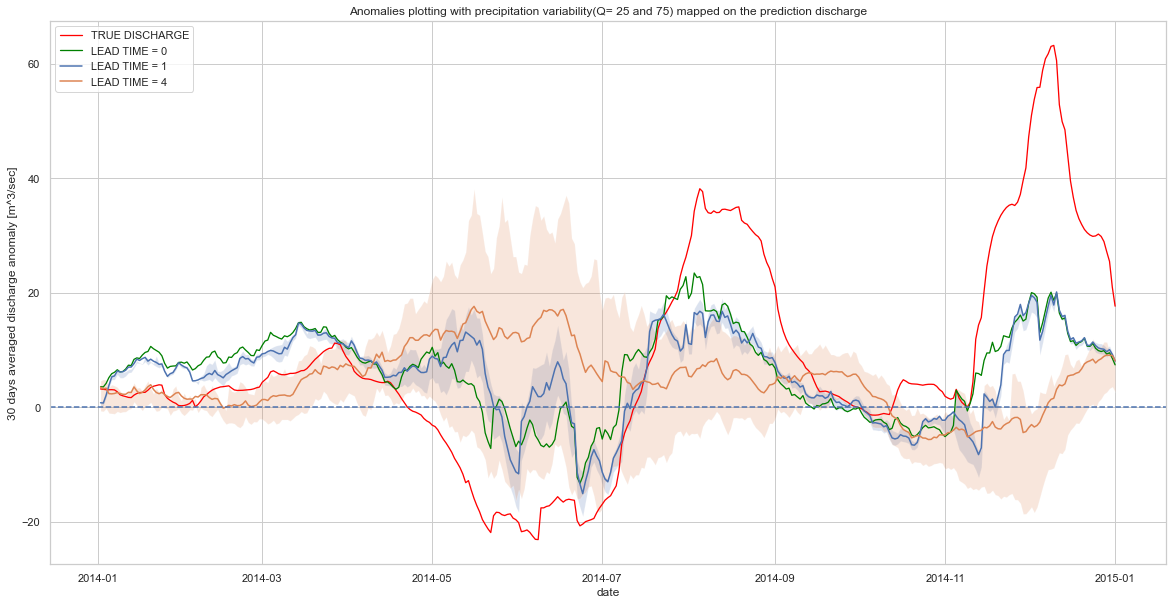

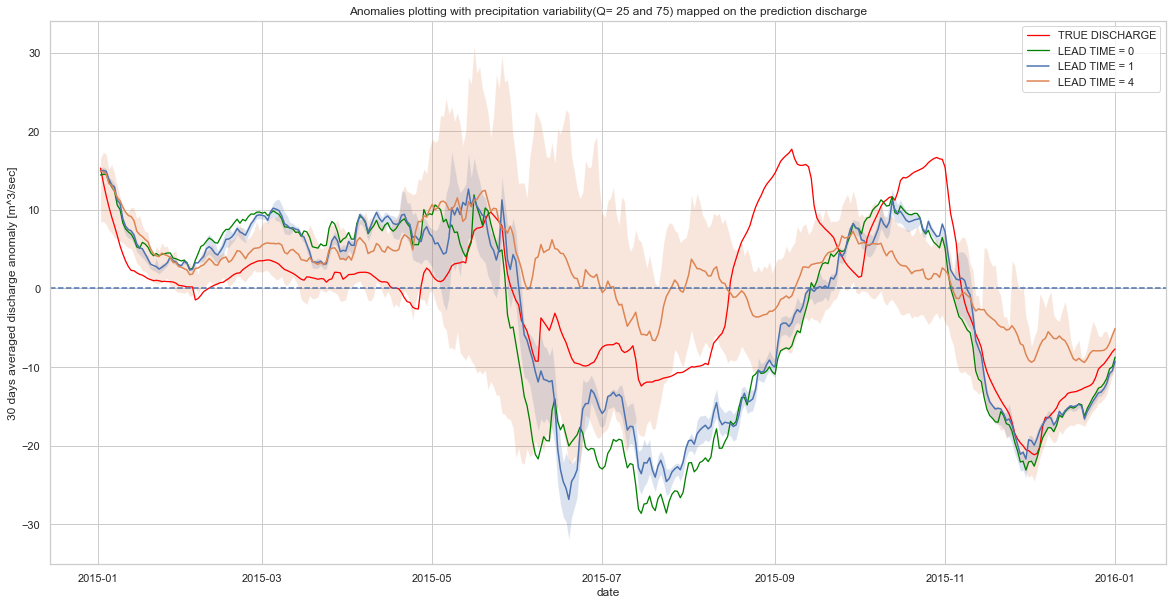

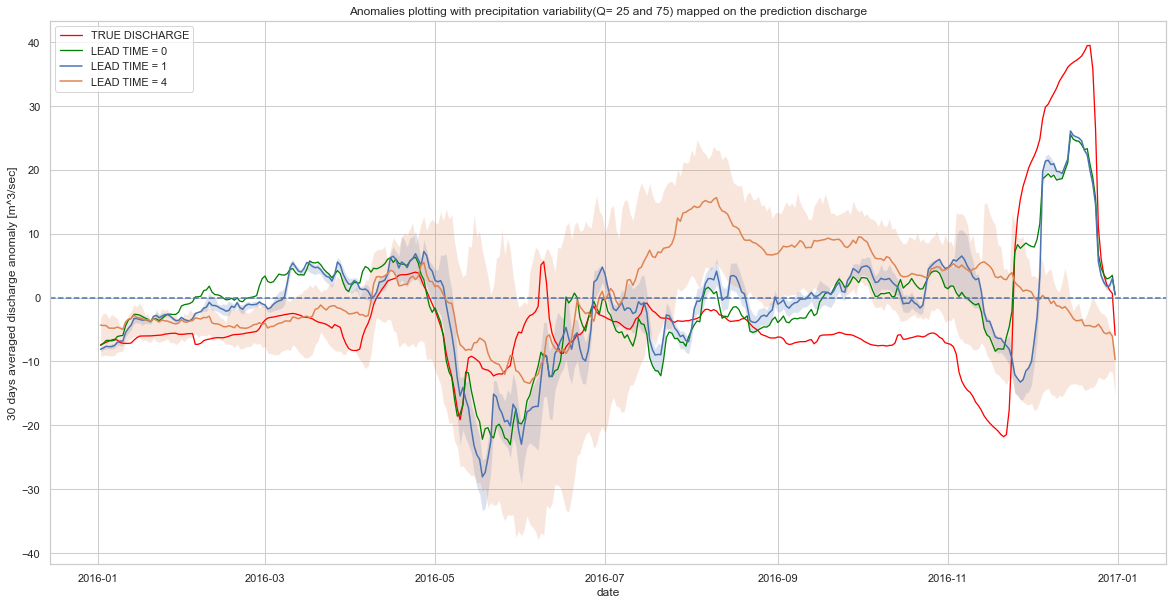

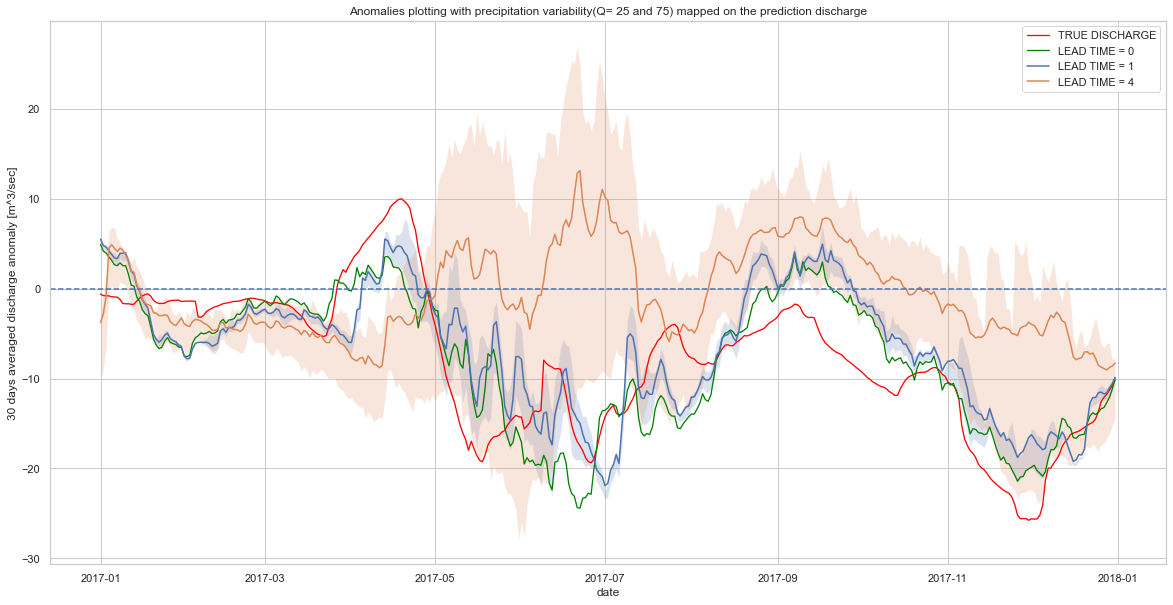

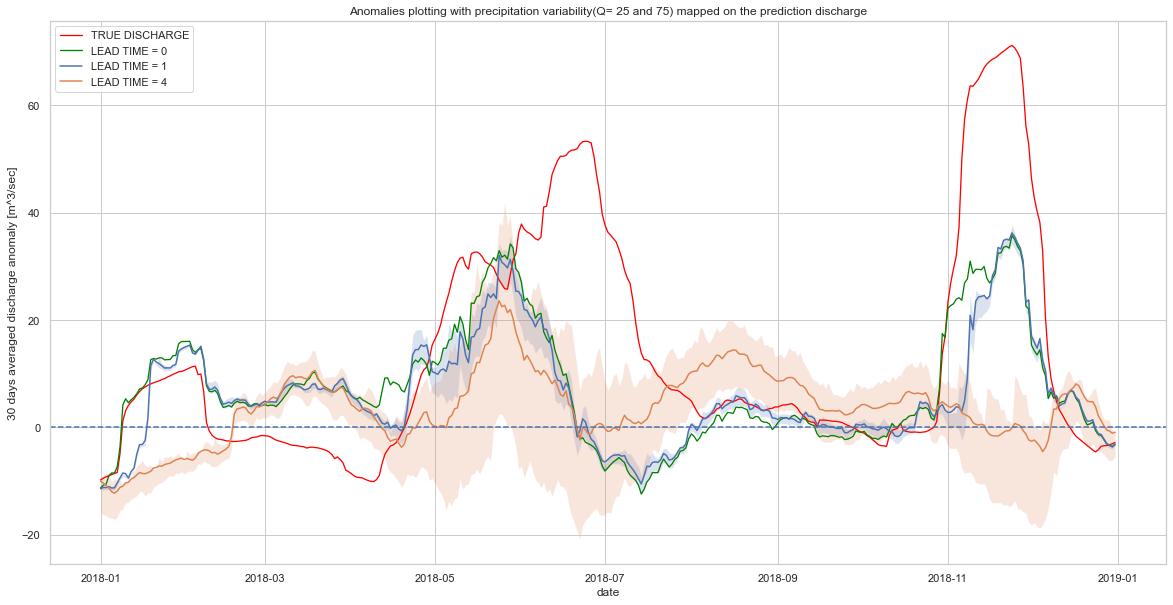

In [101]:
a=compute_anomalies(climatologies, predictions)
a['split']=predictions.split

plot_anomalies(a)

## B) NO_SNOW, T_UNIT = 10

In [14]:
daily_input_stat2 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='S'])

t_unit=10

In [5]:
#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-0.5, 0.5, 5)
epsilon_range=np.logspace(-3, 0, 5)
#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=5
test_size=365

In [15]:
C2, eps2 = SVR_nested_CV_gridsearch(daily_input_stat2, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C2={C2}')
print(f'eps2={eps2}')

Fitting 1 folds for each of 25 candidates, totalling 25 fits


KeyboardInterrupt: 

In [15]:
C2=0.5623413251903491
eps2=0.005623413251903491

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [16]:
radius_for_ensemble = 1
predictions2 = nested_CV_SVR_predict(daily_input_stat2, C2, eps2, t_length, t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

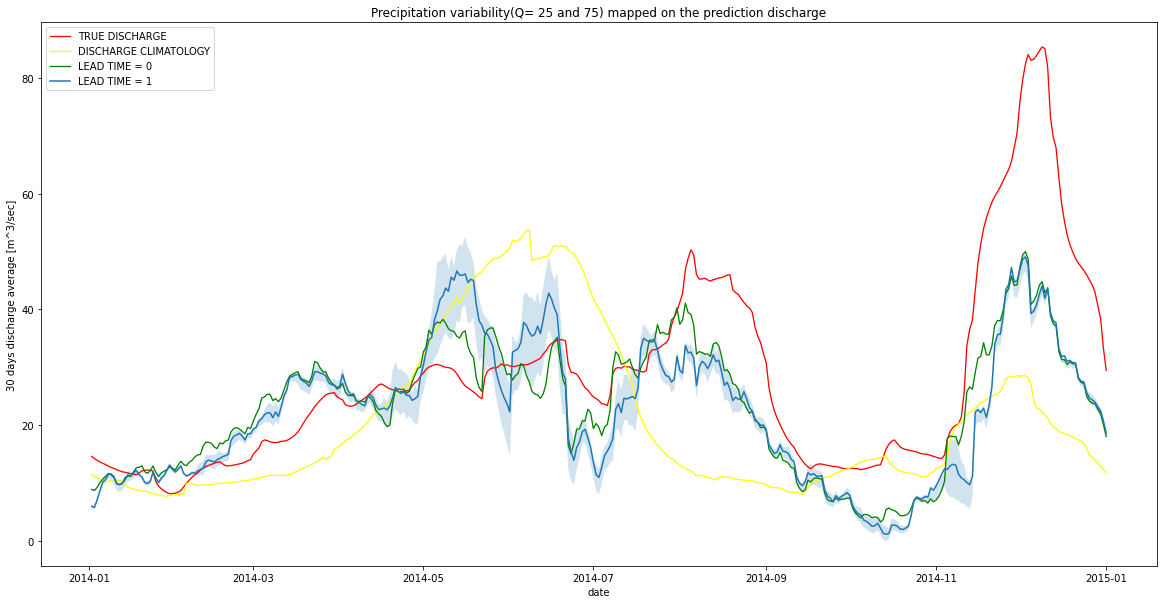

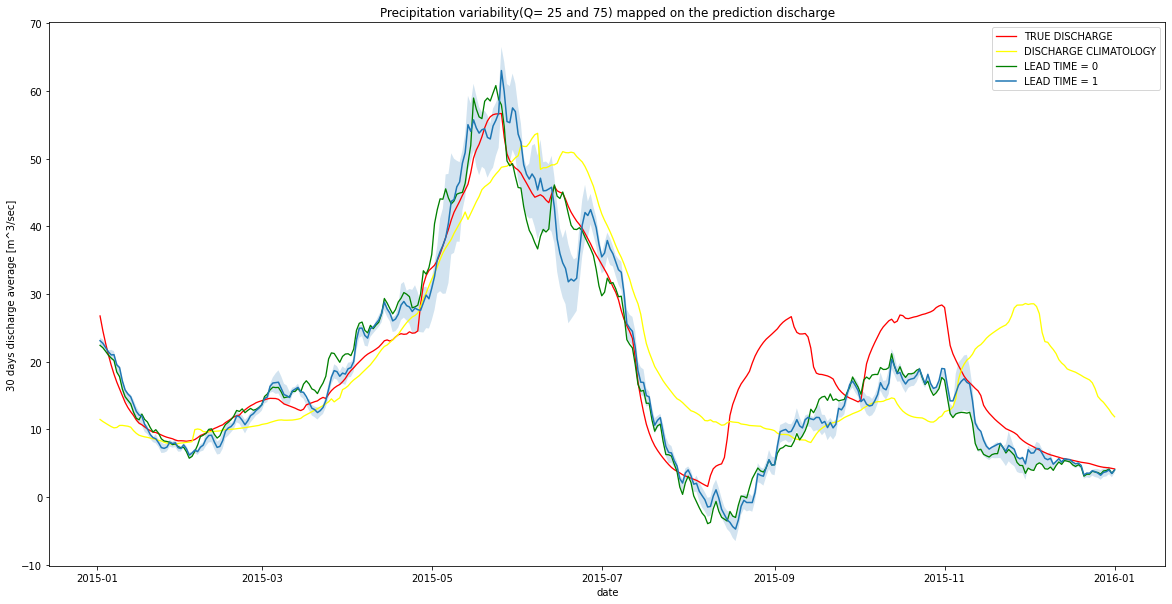

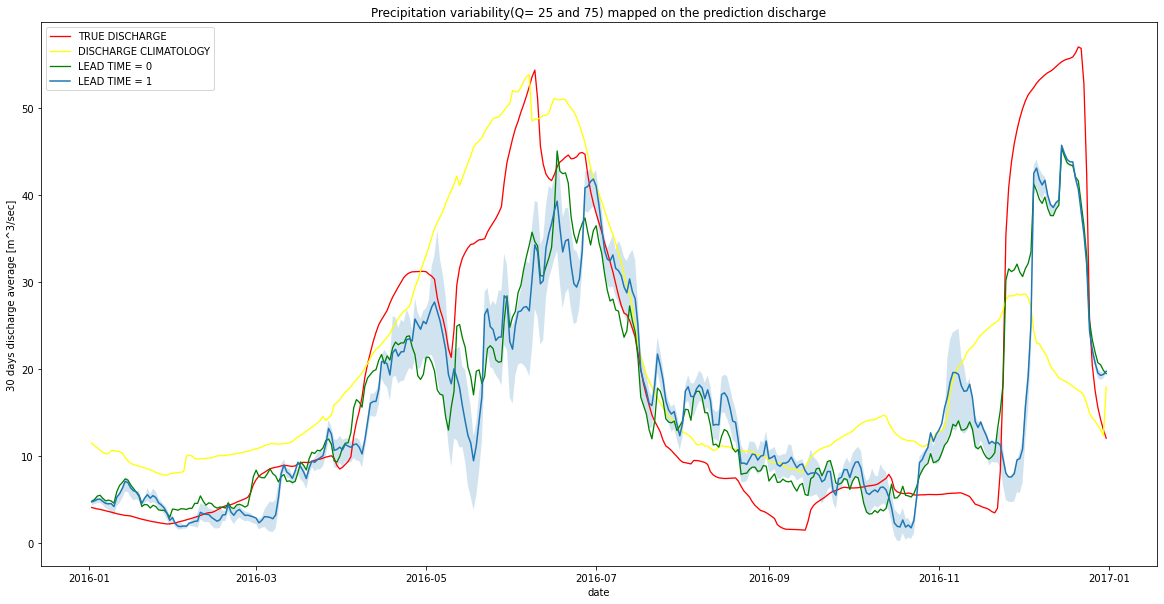

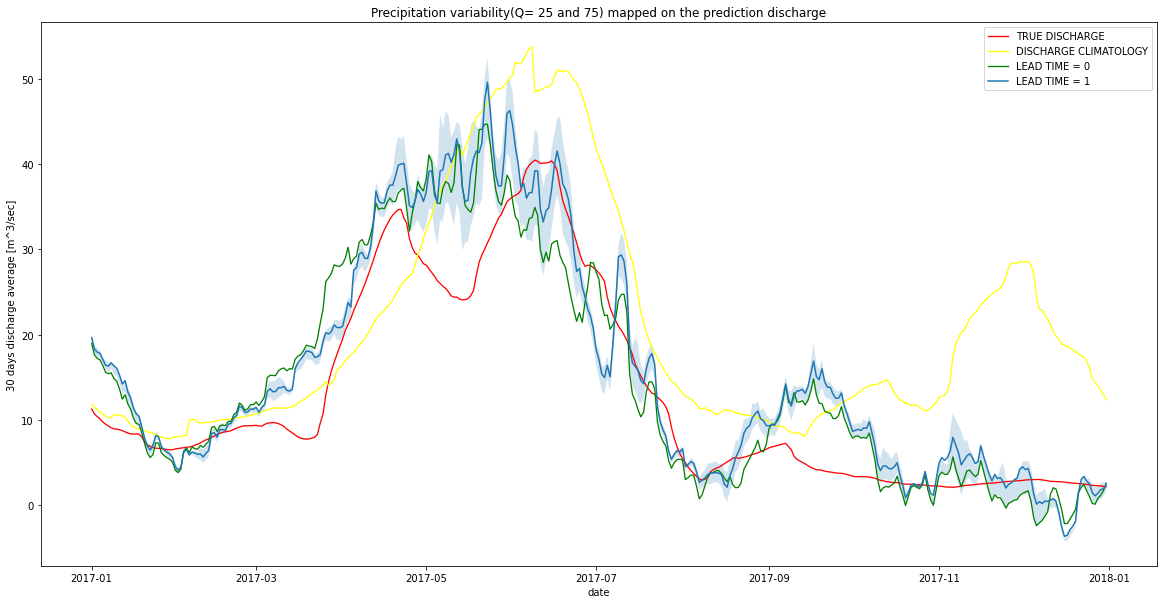

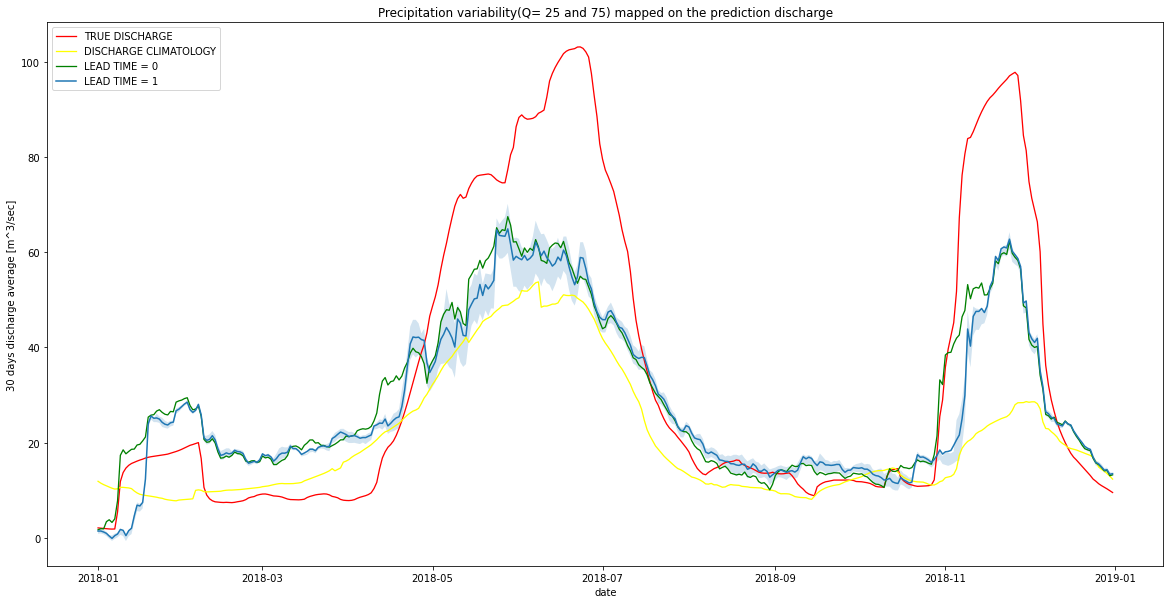

In [17]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions2)

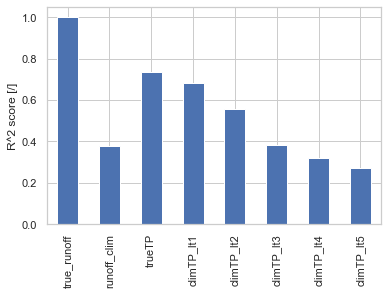

In [83]:
r2_B= evaluate_prediction(predictions2)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [49]:
predictions_for_clim2 = classic_CV_SVR_predict(daily_input_stat2, C2, eps2, t_length, t_unit, n_splits)

In [67]:
climatologies2 =predictions_for_clim2.groupby(by=predictions_for_clim2.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies2['doty']=climatologies2.index


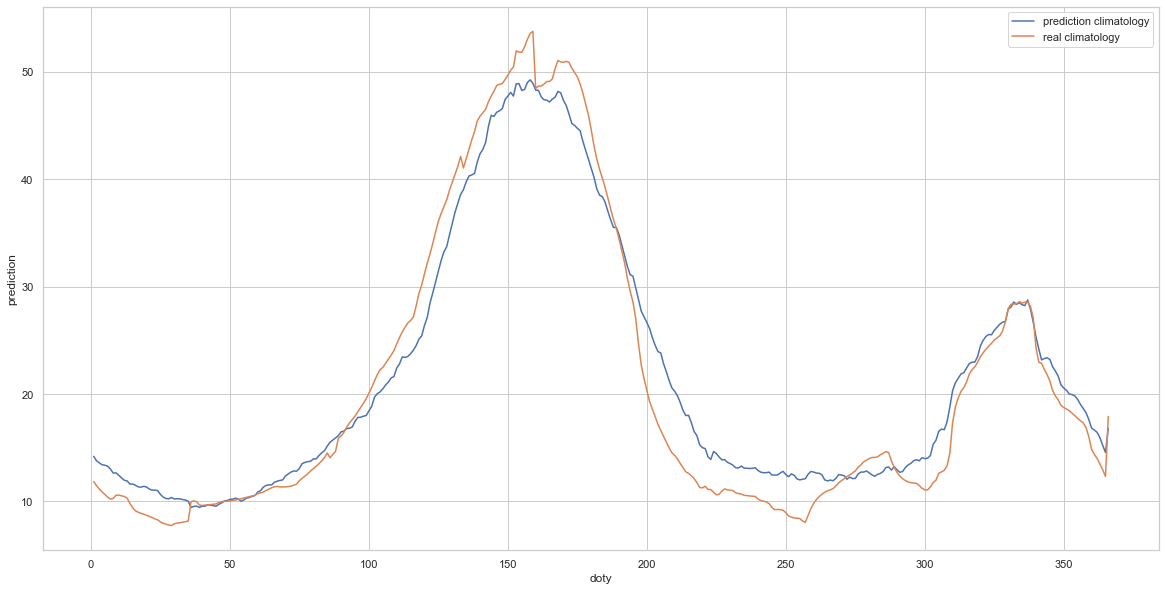

In [68]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

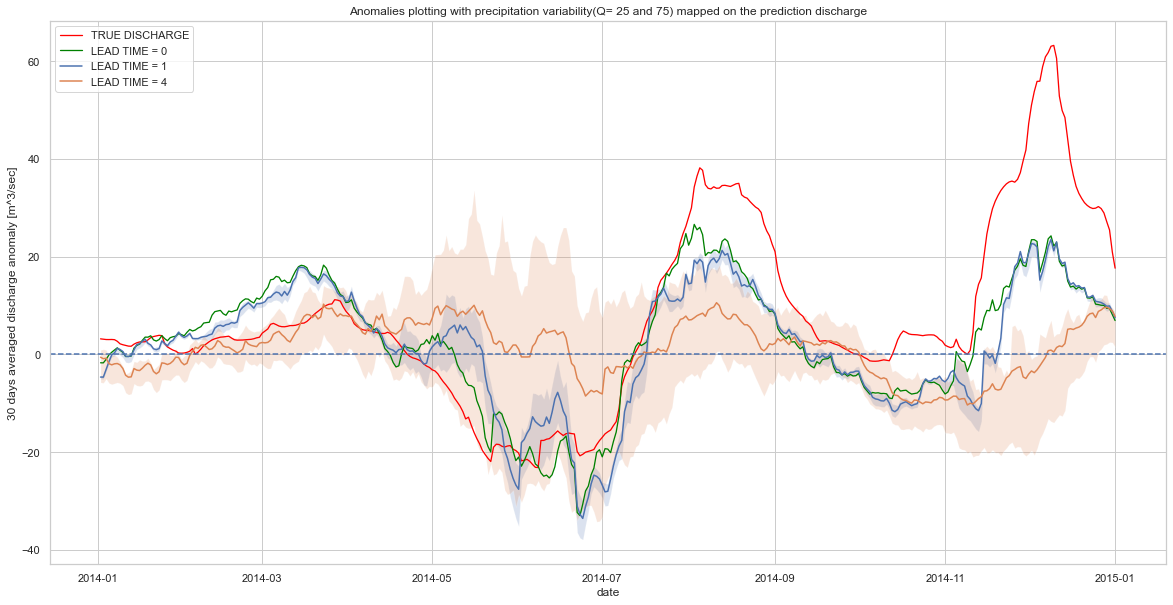

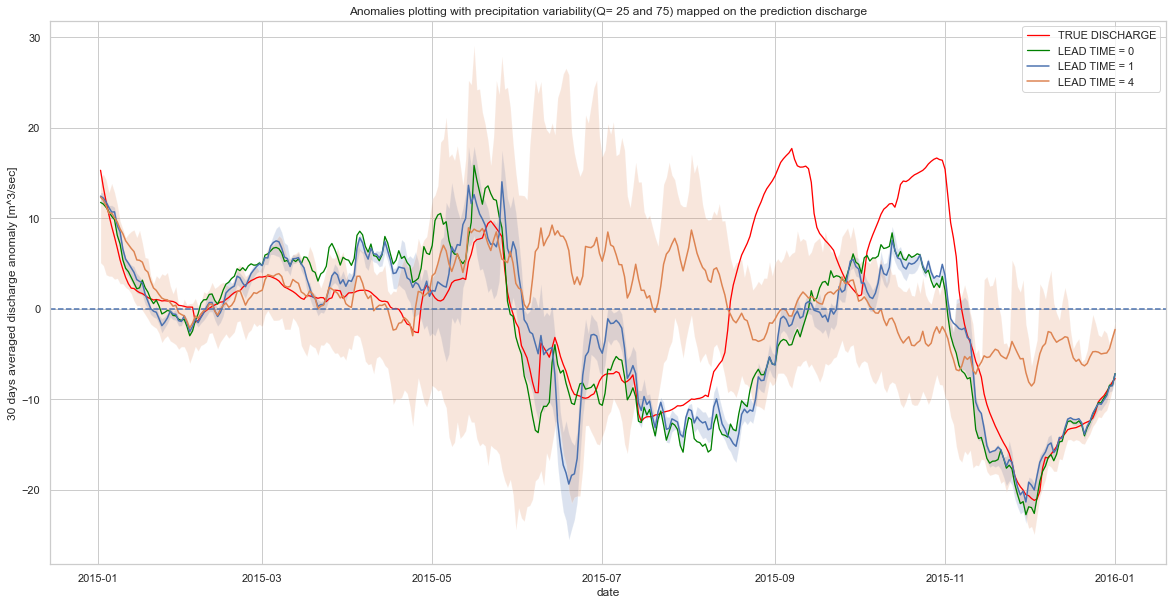

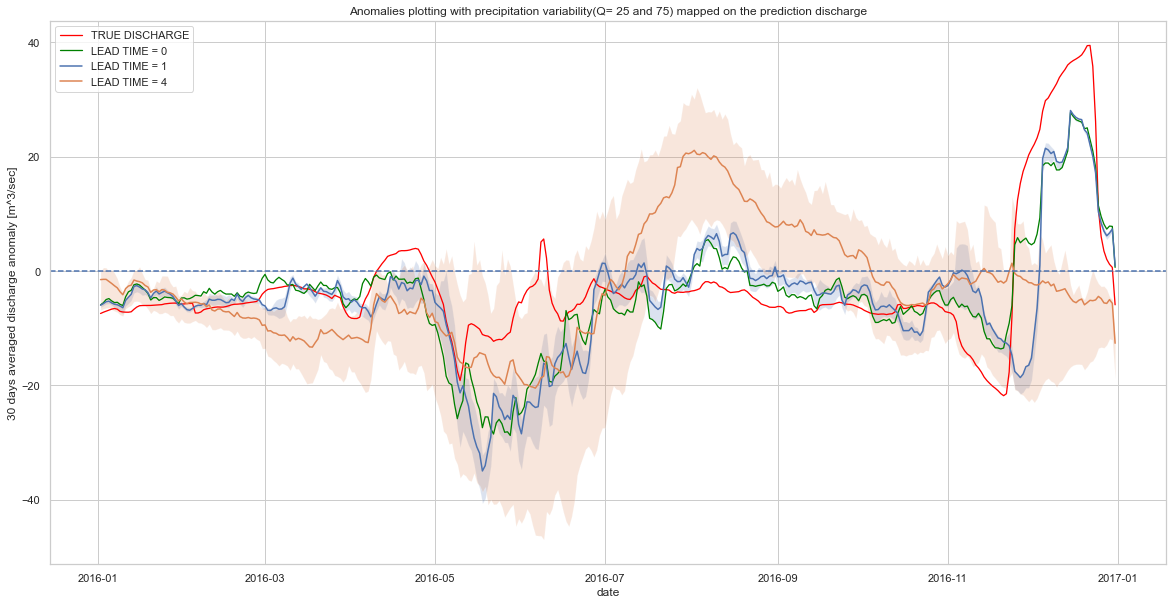

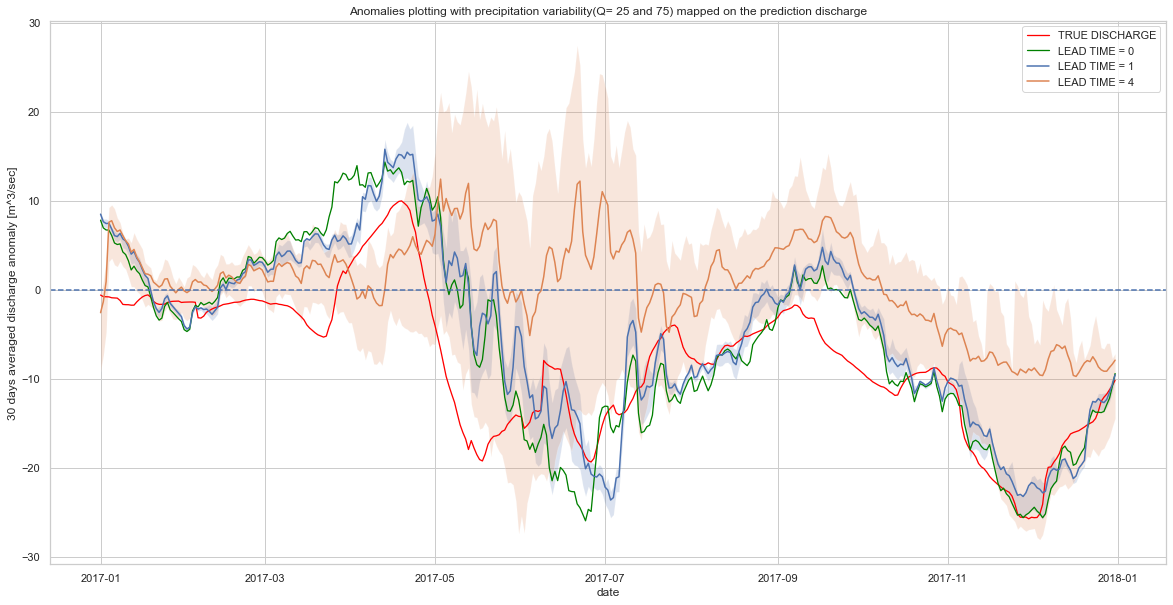

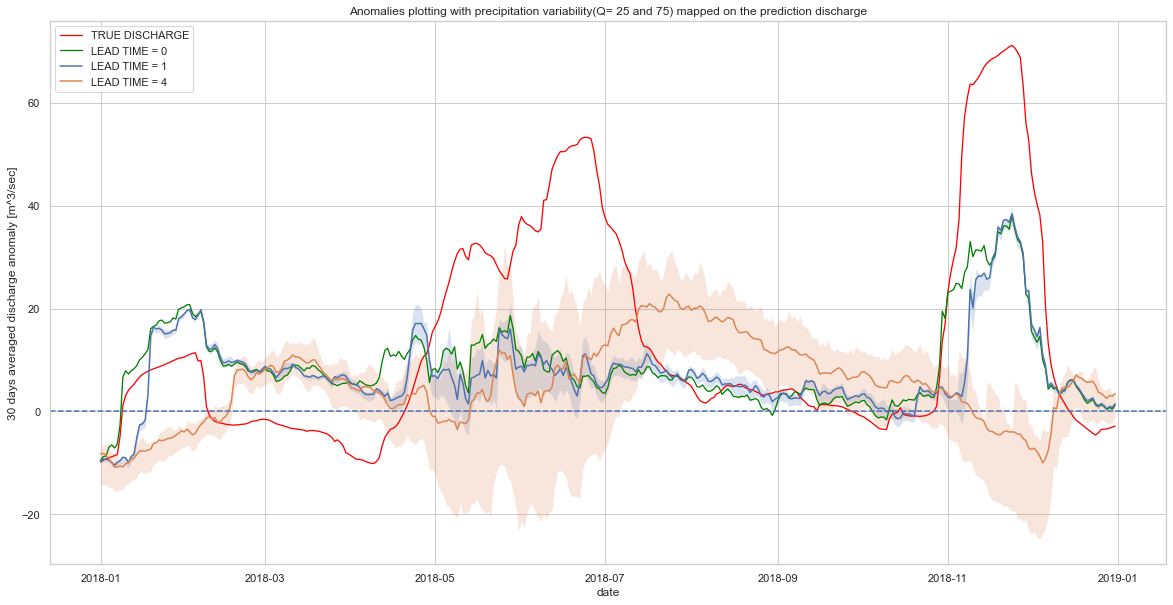

In [77]:
a2=compute_anomalies(climatologies2, predictions2)
a2['split']=predictions2.split

plot_anomalies(a2)

## C) NO_EVAP, T_UNIT = 10

In [26]:
daily_input_stat3 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='E'])

t_unit=10

Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


NameError: name 'C3' is not defined

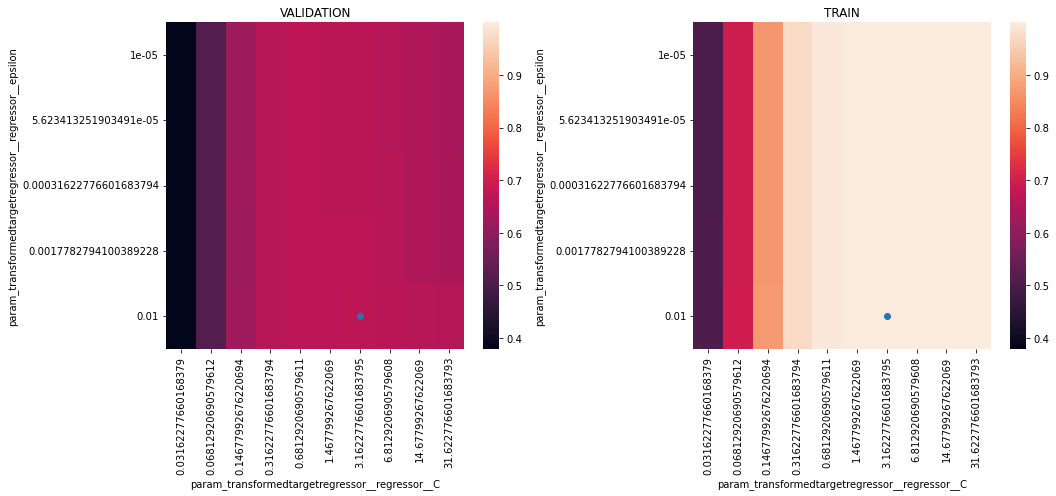

In [27]:
C3, eps3 = SVR_nested_CV_gridsearch(daily_input_stat3, C_range, epsilon_range, t_range, t_unit, n_splits, test_size)
print(f'C3={C3}')
print(f'eps3={eps3}')

In [55]:
C3=3.162277
eps3=0.01

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [57]:
radius_for_ensemble = 1
predictions3 = nested_CV_SVR_predict(daily_input_stat3, C3, eps3, t_length, t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

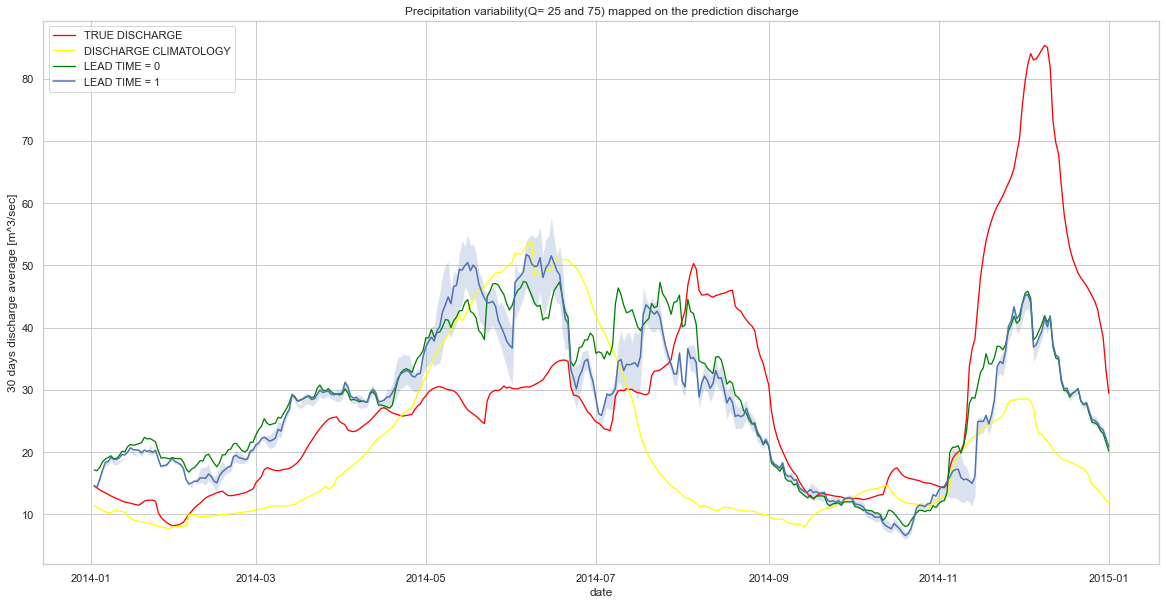

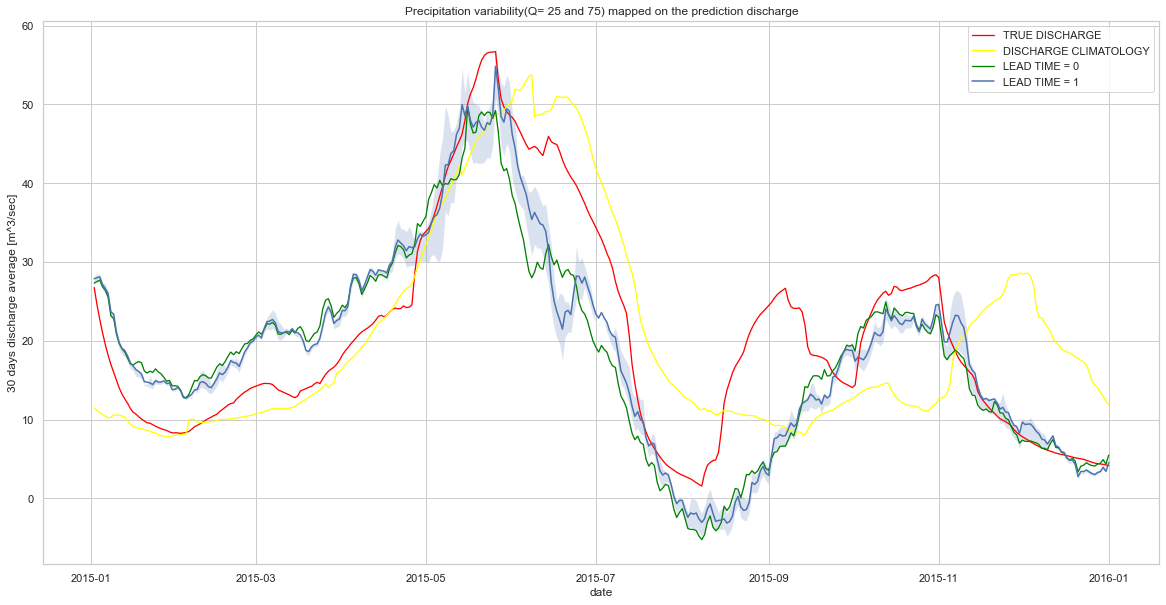

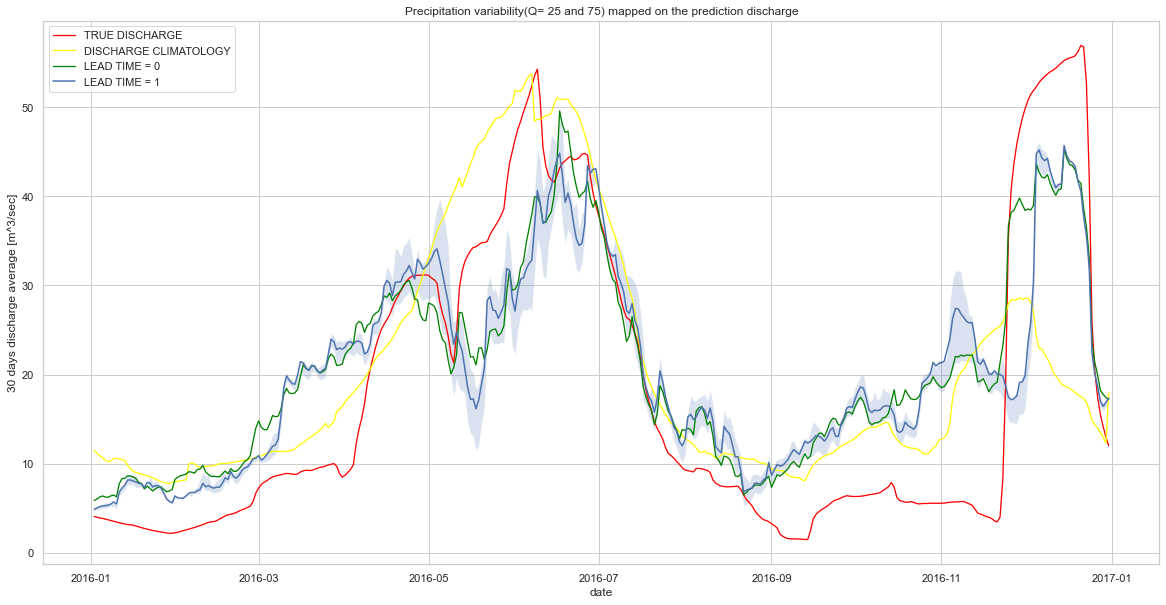

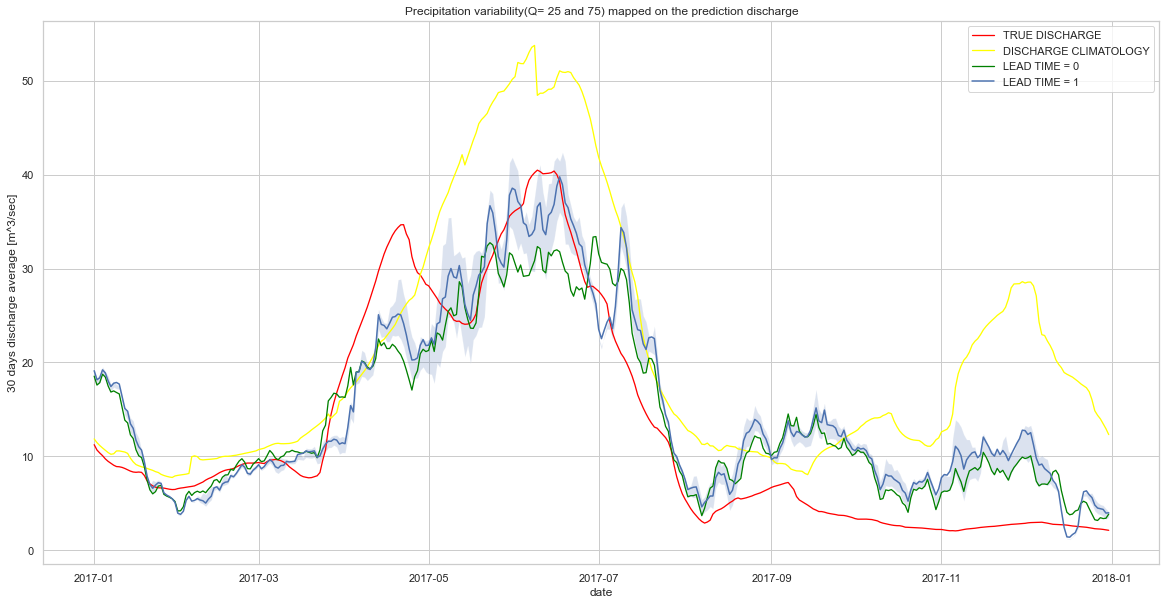

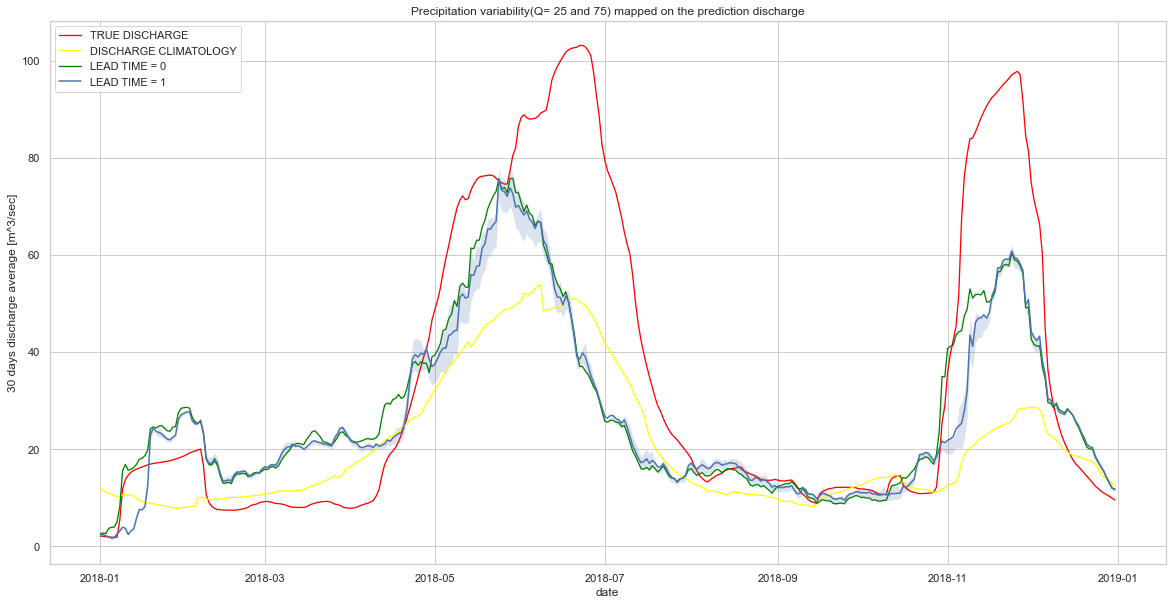

In [58]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions3)

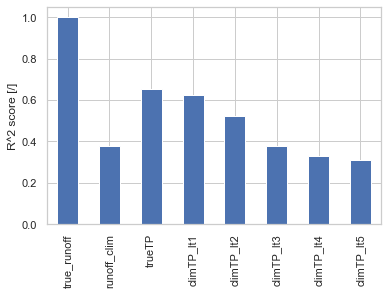

In [82]:
r2_C= evaluate_prediction(predictions3)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [60]:
predictions_for_clim3 = classic_CV_SVR_predict(daily_input_stat3, C3, eps3, t_length, t_unit, n_splits)

In [64]:
climatologies3 =predictions_for_clim3.groupby(by=predictions_for_clim3.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies3['doty']=climatologies3.index


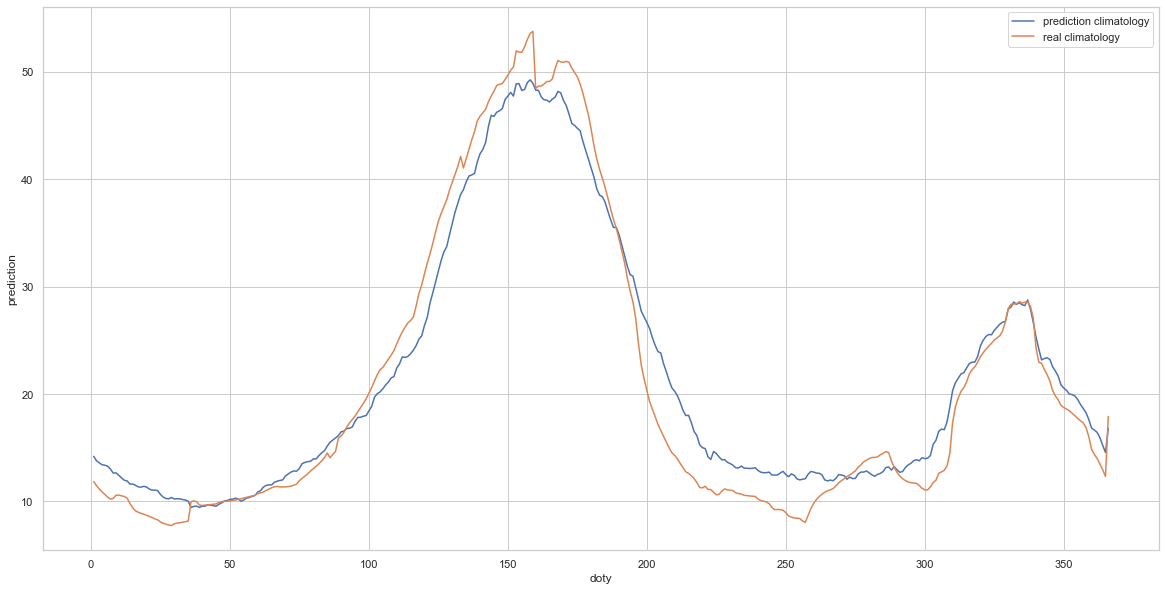

In [65]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

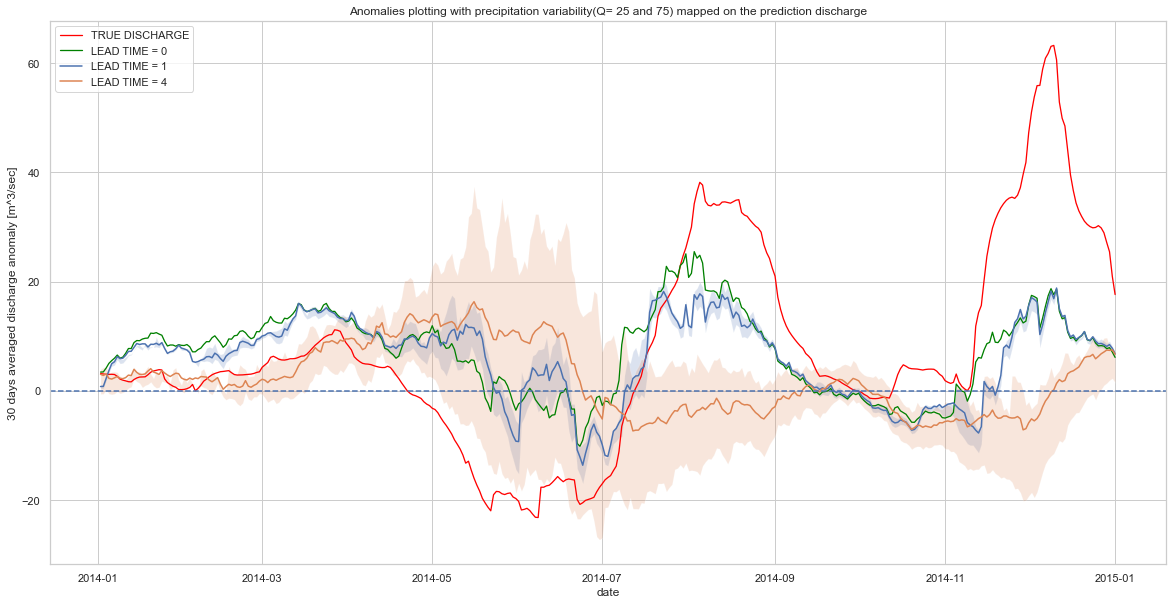

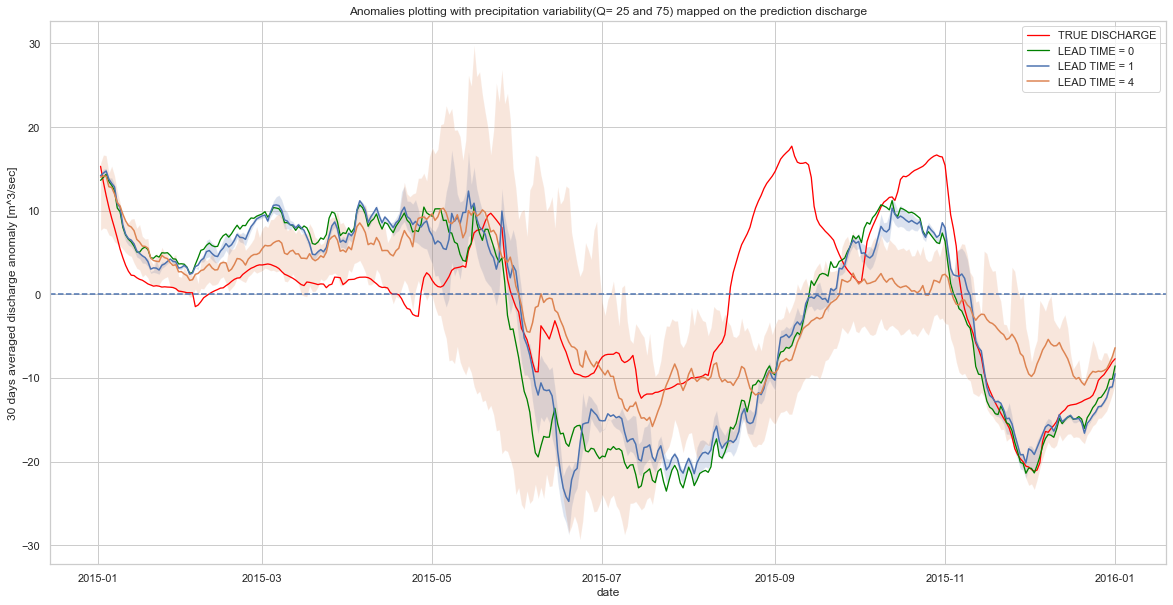

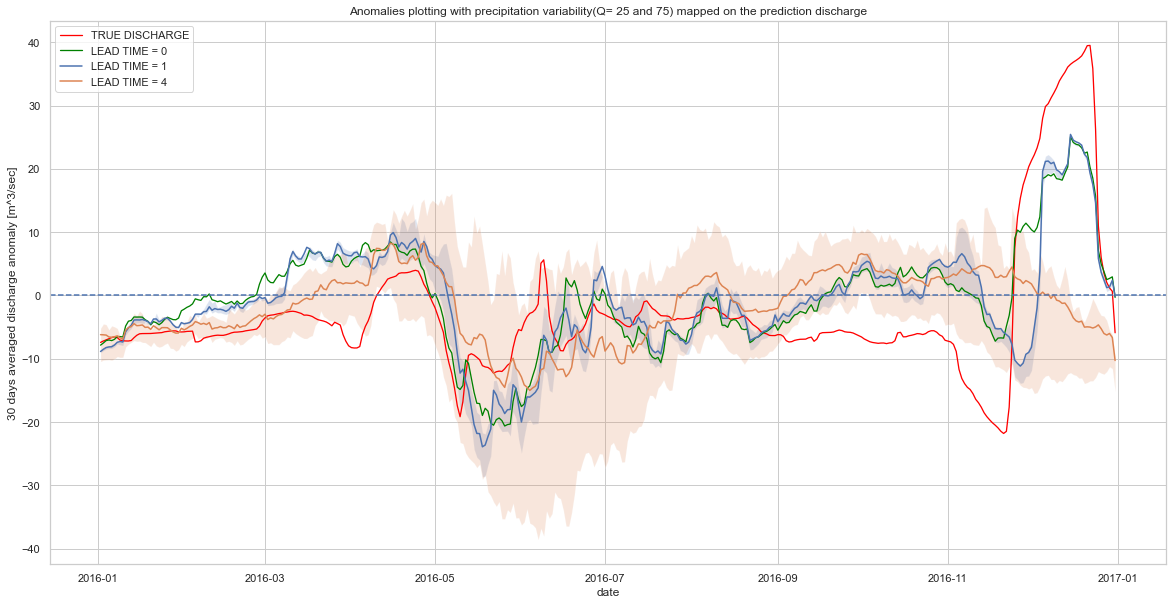

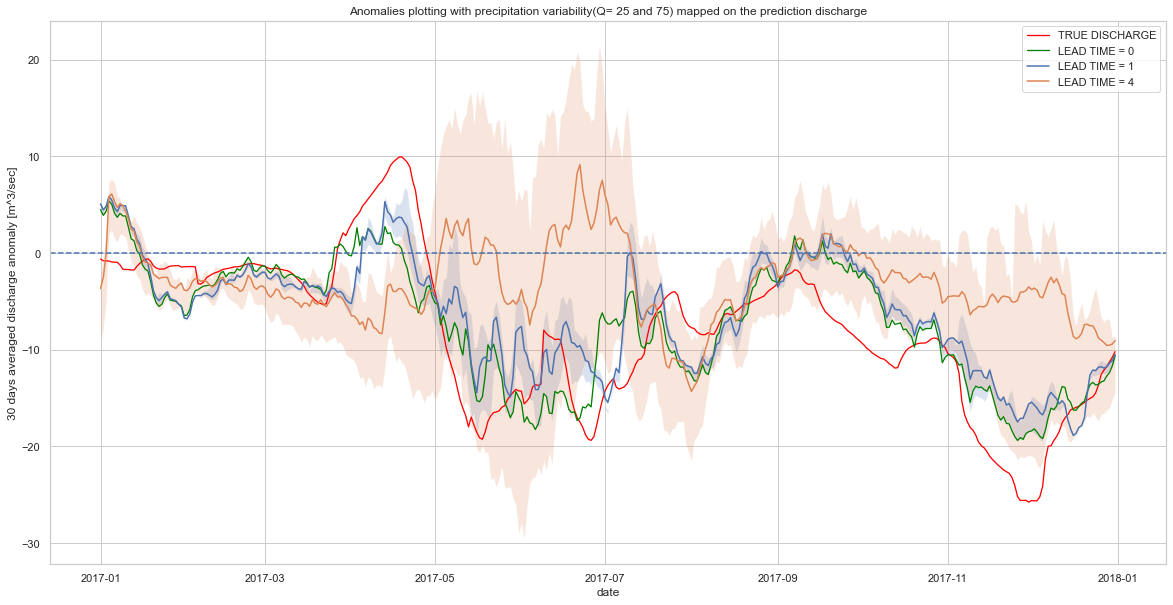

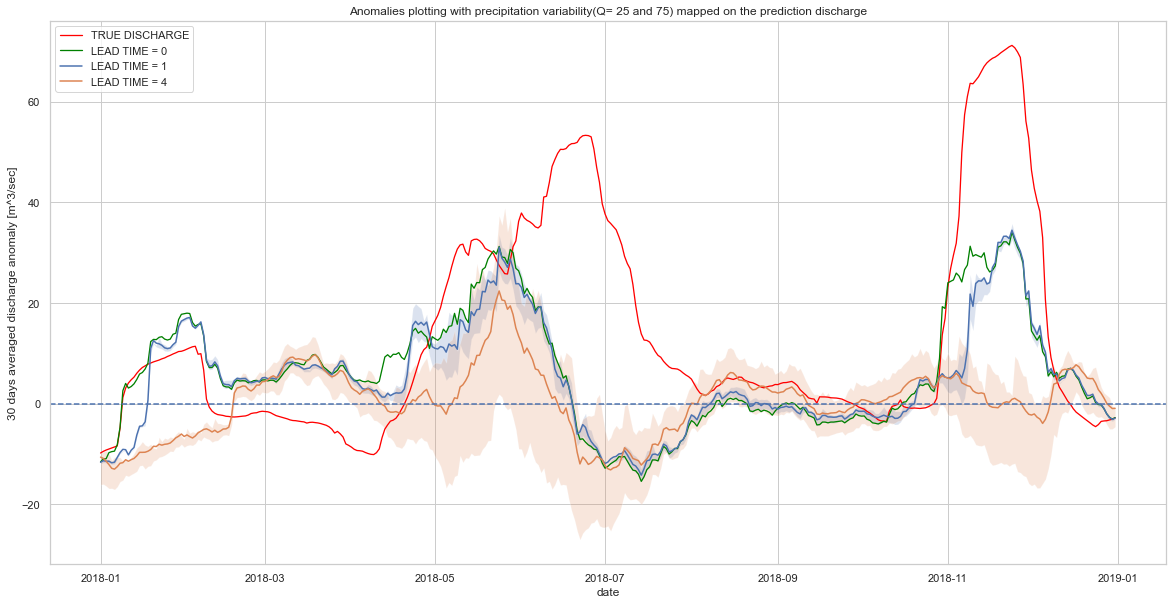

In [76]:
a3=compute_anomalies(climatologies3, predictions3)
a3['split']=predictions3.split

plot_anomalies(a3)

# COMPARE RESULTS

Text(0, 0.5, 'r^2 [/]')

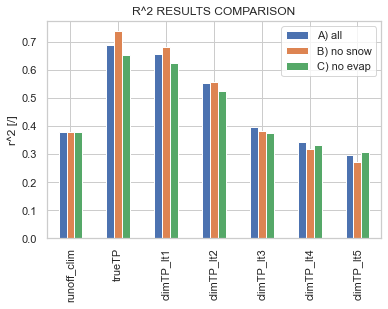

In [102]:
results = pd.concat([r2_A,r2_B,r2_C],axis=1)
results.columns=['A) all','B) no snow','C) no evap']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

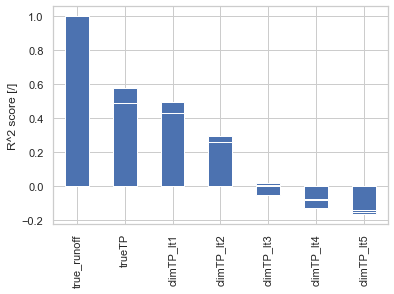

In [103]:
r2_C_a= evaluate_prediction(a3)
r2_B_a = evaluate_prediction(a2)
r2_A_a = evaluate_prediction(a)

Text(0, 0.5, 'r^2 [/]')

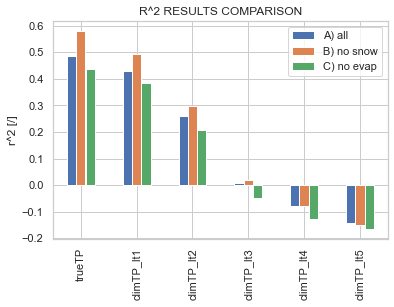

In [104]:
results_a = pd.concat([r2_A_a,r2_B_a,r2_C_a],axis=1)
results_a.columns=['A) all','B) no snow','C) no evap']
results_a.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

In [88]:
arrays = [[np.array(np.repeat((t_unit),8),dtype=object),np.array(results.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results.index=index

results


A) all  B) no snow  C) no evap
t_unit lt                                           
10     true_runoff  1.000000    1.000000    1.000000
       runoff_clim  0.378261    0.378261    0.378261
       trueTP       0.688959    0.737788    0.653299
       climTP_lt1   0.654172    0.681836    0.624609
       climTP_lt2   0.551938    0.557860    0.524001
       climTP_lt3   0.397701    0.383904    0.376032
       climTP_lt4   0.342469    0.319416    0.330882
       climTP_lt5   0.300238    0.272675    0.308422

In [89]:
arrays = [[np.array(np.repeat((t_unit),7),dtype=object),np.array(results_a.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results_a.index=index

results_a

A) all  B) no snow  C) no evap
t_unit lt                                           
10     true_runoff  1.000000    1.000000    1.000000
       trueTP       0.484034    0.580255    0.438669
       climTP_lt1   0.426081    0.493457    0.383641
       climTP_lt2   0.256863    0.298342    0.205942
       climTP_lt3   0.006604    0.021162   -0.049241
       climTP_lt4  -0.077086   -0.079113   -0.127682
       climTP_lt5  -0.135684   -0.149620   -0.163437

In [91]:
results.to_csv('results/SAN_BENIGNO__10.csv')
results_a.to_csv('results/SAN_BENIGNO__10_a.csv')